<a href="https://colab.research.google.com/github/Rahullnitp/IEEE-CIS-Fraud-Detection/blob/master/IEEE_CIS__FRAUD_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Date-28/08/2019

In this project i will use classification method on the given dataset and find out which of these instances are seem to be fraud.

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = 'rahul1704031'
os.environ['KAGGLE_KEY'] = 'xxxxxxxxxxxxx'

In [0]:
!kaggle competitions download -c ieee-fraud-detection

 88% 46.0M/52.5M [00:00<00:00, 84.8MB/s]
100% 52.5M/52.5M [00:00<00:00, 151MB/s] 
  0% 0.00/3.02M [00:00<?, ?B/s]
100% 3.02M/3.02M [00:00<00:00, 100MB/s]
 53% 25.0M/47.3M [00:00<00:00, 56.9MB/s]
100% 47.3M/47.3M [00:00<00:00, 120MB/s] 
  0% 0.00/2.97M [00:00<?, ?B/s]
100% 2.97M/2.97M [00:00<00:00, 202MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 165MB/s]


In [0]:
!pip3 install catboost

     |████████████████████████████████| 61.9MB 70.9MB/s 


In [0]:
import os
import time
import datetime
import json
import gc
from numba import jit    #numba is an open source JIT compiler that translates a subset of python and numpy into fast macine code like LLVM.

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics

from itertools import product

import altair as alt
from altair.vega import v5  #Altair is a declarative statistical visualization library in Python, based on Vega-lite .
from IPython.display import HTML

# using ideas from this kernel: https://www.kaggle.com/notslush/altair-visualization-2018-stackoverflow-survey
def prepare_altair():
    """
    Helper function to prepare altair for working.
    """

    vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v5.SCHEMA_VERSION
    vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
    vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
    vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
    noext = "?noext"
    
    paths = {
        'vega': vega_url + noext,
        'vega-lib': vega_lib_url + noext,
        'vega-lite': vega_lite_url + noext,
        'vega-embed': vega_embed_url + noext
    }
    
    workaround = f"""    requirejs.config({{
        baseUrl: 'https://cdn.jsdelivr.net/npm/',
        paths: {paths}
    }});
    """
    
    return workaround
    

def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
           

@add_autoincrement
def render(chart, id="vega-chart"):
    """
    Helper function to plot altair visualizations.
    """
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )
    

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
    

@jit
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True


def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()
    

def train_model_regression(X, X_test, y, params, folds=None, model_type='lgb', eval_metric='mae', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000, splits=None, n_folds=3):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    X_test = X_test[columns]
    splits = folds.split(X) if splits is None else splits
    n_splits = folds.n_splits if splits is None else n_folds
    
    # to set up scoring parameters
    metrics_dict = {'mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'sklearn_scoring_function': metrics.mean_absolute_error},
                    'group_mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'scoring_function': group_mean_log_mae},
                    'mse': {'lgb_metric_name': 'mse',
                        'catboost_metric_name': 'MSE',
                        'sklearn_scoring_function': metrics.mean_squared_error}
                    }

    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X))
    
    # averaged predictions on train data
    prediction = np.zeros(len(X_test))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(splits):
        if verbose:
            print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        if eval_metric != 'group_mae':
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
        else:
            scores.append(metrics_dict[eval_metric]['scoring_function'](y_valid, y_pred_valid, X_valid['type']))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_splits
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict
    


def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000, splits=None, n_folds=3, averaging='usual', n_jobs=-1):
    """
    A function to train a variety of classification models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    n_splits = folds.n_splits if splits is None else n_folds
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    if averaging == 'usual':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))
        
    elif averaging == 'rank':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))

    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = n_jobs)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1]
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict_proba(X_test)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators, eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=Logloss)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        if averaging == 'usual':
            
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
            
            prediction += y_pred.reshape(-1, 1)

        elif averaging == 'rank':
                                  
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
                                  
            prediction += pd.Series(y_pred).rank().values.reshape(-1, 1)        
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
            result_dict['top_columns'] = cols
        
    return result_dict

# setting up altair
workaround = prepare_altair()
HTML("".join((
    "<script>",
    workaround,
    "</script>",
)))

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
import gc
from itertools import cycle, islice
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
%matplotlib inline

In [0]:
train_transact = pd.read_csv('train_transaction.csv.zip', compression='zip', header=0, sep=',', quotechar='"')
test_transact=pd.read_csv('test_transaction.csv.zip', compression='zip', header=0, sep=',', quotechar='"')
train_id=pd.read_csv('train_identity.csv.zip', compression='zip', header=0, sep=',', quotechar='"')
test_id=pd.read_csv('test_identity.csv.zip', compression='zip', header=0, sep=',', quotechar='"')
sample_submission=pd.read_csv('sample_submission.csv.zip', compression='zip', header=0, sep=',', quotechar='"')

In [0]:
train_transact.shape

(590540, 394)

In [0]:
train_transact.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
train_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [0]:
train=train_transact.merge(train_id,on='TransactionID',how='left')
test=test_transact.merge(test_id,on='TransactionID',how='left')

In [0]:
train.describe(include='all')

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540,590540.000000,581607.000000,588975.000000,588963,586281.000000,588969,524834.000000,524834.000000,238269.000000,37627.000000,496084,137291,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,...,144233.000000,140872.000000,66324.000000,66324.000000,136865.000000,136865.000000,5155.000000,5155.000000,74926.000000,74926.000000,140978.000000,144233,127320.000000,80044.000000,140985,129340,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,5169,4747.000000,5132.000000,5163.000000,5169,140978,140978,77565,140282,77586.000000,73289,77805,140985,140985,140985,140985,140810,118666
unique,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,4,NaN,4,NaN,NaN,NaN,NaN,59,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2,2,2,75,130,NaN,260,4,2,2,2,2,2,1786
top,NaN,NaN,NaN,NaN,W,NaN,NaN,NaN,visa,NaN,debit,NaN,NaN,NaN,NaN,gmail.com,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NotFound,NaN,NaN,Found,Found,NaN,NaN,NaN,NaN,NaN,NaN,IP_PROXY:TRANSPARENT,NaN,NaN,NaN,Found,Found,Found,Windows 10,chrome 63.0,NaN,1920x1080,match_status:2,T,F,T,F,desktop,Windows
freq,NaN,NaN,NaN,NaN,439670,NaN,NaN,NaN,384767,NaN,439938,NaN,NaN,NaN,NaN,228355,57147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123025,NaN,NaN,67728,66324,NaN,NaN,NaN,NaN,NaN,NaN,3489,NaN,NaN,NaN,5155,76232,74926,21155,22000,NaN,16874,60011,77814,134066,110452,73922,85165,47722
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,NaN,9898.734658,362.555488,153.194925,NaN,199.278897,NaN,290.733794,86.800630,118.502180,231.855423,NaN,NaN,14.092458,15.269734,0.005644,4.092185,5.571526,9.071082,2.848478,5.144574,4.480240,5.240343,10.241521,4.076227,32.539918,8.295215,94.347568,169.563231,28.343348,140.002441,42.335965,69.805717,41.638950,146.058108,0.561057,...,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.698710,13.285354,-38.600388,0.091023,-0.301124,99.745325,NaN,48.053071,-344.507146,NaN,NaN,189.451377,14.237337,353.128174,403.882666,368.269820,16.002708,NaN,12.800927,329.608924,149.070308,NaN,NaN,NaN,NaN,NaN,26.508597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.704744e+05,0.183755,4.617224e+06,239.162522,NaN,4901.170153,157.793246,11.336444,NaN,41.244453,NaN,101.741072,2.690623,371.872026,529.053494,NaN,NaN,133.569018,154.668899,0.150536,68.848459,25.786976,71.508467,61.727304,95.378574,16.674897,95.581443,94.336292,86.666218,129.364844,49.544262,157.660387,177.315865,62.384721,191.096774,89.000144,143.669253,99.743264,231.663840,0.316880,...,14.347949,159651.816856,0.598231,0.701015,5.249856,16.491104,11.384207,26.084899,0.983842,2.789446,1.127602,NaN,11.774858,93.695502,NaN,NaN,30.375360,1.561302,141.095343,152.160327,198.847038,6.897665,NaN,2.372447,97.461089,32.101995,NaN,NaN,NaN,NaN,NaN,3.737502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2.987000e+06,0.000000,8.640000e+04,0.251000,NaN,1000.000000,100.000000,100.000000,NaN,100.000000,NaN,100.000000,1

In [0]:
print(train.shape)
print(test.shape)

(590540, 434)
(506691, 433)


In [0]:
data_total=pd.concat([train,test],ignore_index=True)
del data_total['isFraud']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [0]:
del train_transact,train_id,test_transact,test_id

In [0]:
print('There are {} columns in train dataset with missing values'.format(train.isnull().any().sum()))

There are 414 columns in train dataset with missing values


In [0]:
# .nunique returns no. of unique values

train_unique_value_column=[col for col in train.columns if train[col].nunique()<=1]
test_unique_value_column=[col for col in test.columns if test[col].nunique()<=1]
len(train_unique_value_column)

0

unique value column in the training set is 0.

In [0]:
data_total['id_01'].value_counts(dropna=False,normalize=True).head()

 NaN     0.739216
-5.0     0.150150
 0.0     0.028759
-10.0    0.021007
-20.0    0.020361
Name: id_01, dtype: float64

##Data preparation
removal of column with excess of null values

In [0]:
null_cols_train=[col for col in train.columns if train[col].isnull().sum()/train.shape[0]>0.9]
null_cols_test=[col for col in test.columns if test[col].isnull().sum()/test.shape[0]>0.9]

In [0]:
big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

In [0]:
cols_to_drop=list(set(null_cols_train+null_cols_test+big_top_value_cols+big_top_value_cols_test+train_unique_value_column+test_unique_value_column))
cols_to_drop.remove('isFraud')
len(cols_to_drop)

82

In [0]:
train=train.drop(cols_to_drop,axis=1)
test=test.drop(cols_to_drop,axis=1)

In [0]:
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9',
            'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']
for col in cat_cols:
    if col in train.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))

In [0]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
#X_test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)
X_test = test.drop(['TransactionDT', 'TransactionID'], axis=1)
del train
test = test[["TransactionDT", 'TransactionID']]

In [0]:
# by https://www.kaggle.com/dimartinot
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   

# Cleaning infinite values to NaN
X = clean_inf_nan(X)
X_test = clean_inf_nan(X_test )

##Data Exploration

From id information ,

1.Categorical variables are:

  * id_12 to id_38

  * DeviceInfo

  * DeviceType

2.Continuous variables are:

  * id_01 to id_11












In [0]:
# # For visualisation purpose

# def feature_plot(X,Y,continuous):
  
#   Data=data_total[:8523]
    
#   x = Data[X]
#   y = Data[Y]
  
  
#   if continuous:    # if the data in the given feature is continuous
    
#     fig = plt.figure(constrained_layout=True,figsize=(17,6))

#     # ----- assigning grid to for plotting 
    
#     gs = gridspec.GridSpec(8, 8, figure=fig)
#     ax1 = fig.add_subplot(gs[0:2, 5:7])
#     ax2 = fig.add_subplot(gs[0:, 0:3])
#     ax4 = fig.add_subplot(gs[2:,5:7])
#     ax3 = fig.add_subplot(gs[2:,7:8])
    
#   # # #------plot-----
    
#      #-----PLOT WITHOUT "Item_Outlet_Sales"-----
    
#     sns.distplot(x, kde=False, ax=ax2)
    
#      #  -----PLOT WITH "Item_Outlet_Sales"------
    
#     ax4.scatter(x,y)
#     ax1.hist(x,bins=70)
#     ax3.hist(y,bins=70,orientation="horizontal")
    
#     #   fig.suptitle("GridSpec")

# # Turn off tick labels on marginals
#     plt.setp(ax1.get_xticklabels(), visible=False)
#     plt.setp(ax3.get_yticklabels(), visible=False)

# # Set labels on joint
#     ax4.set_xlabel(X)
#     ax4.set_ylabel(Y)

# # Set labels on marginals
#     ax3.set_xlabel(Y+' count')
#     ax1.set_ylabel(X+' count')
    
#   else:     # if the data in the given feature is not continuous .
    
#     fig,(ax5,ax6)=plt.subplots(nrows=1,ncols=2, figsize=(16,5),dpi=90)
    
#     #-----PLOT WITHOUT "Item_Outlet_Sales"-----
    
#     #Show the counts of observations in each categorical bin using bars.
#     count=sns.countplot(x, order=sorted(x.unique()), color='#597500', saturation=1, ax=ax5)                                                                                                 
#     count.set_xticklabels(count.get_xticklabels(), rotation=80)
#     ax5.set_title(X+' count')
                                                                                                       
    
#     #  -----PLOT WITH "Item_Outlet_Sales"------
    
#     sns.boxplot(x=x, y=y, data=Data)
# #                                                         cat_df_flights = df_flights.select_dtypes(include=['object']).copy()              #sns.catplot(x="Outlet_Type", y="Item_Outlet_Sales", kind="boxen",data=Data);
#     ax6.set_ylabel('Item_Outlet_Sales')
#     ax6.set_title('Item_Outlet_Sales by '+X)
#     plt.xticks(rotation = 80)
#   plt.show()


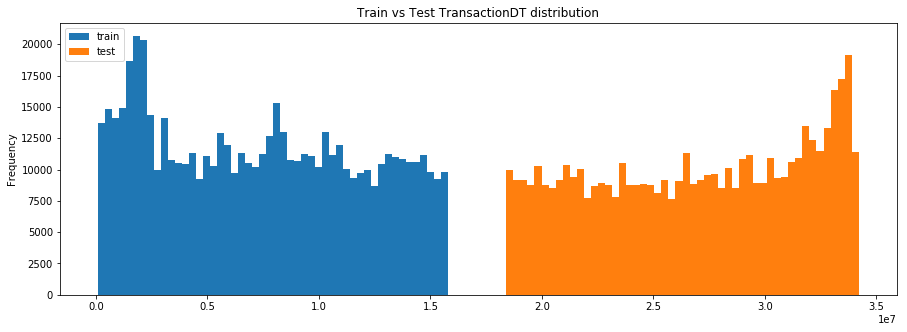

In [0]:
# TransactionDt analysis
train_transact['TransactionDT'].plot(kind='hist',
                                        figsize=(15, 5),
                                        label='train',
                                        bins=50,
                                        title='Train vs Test TransactionDT distribution')
test_transact['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=50)
plt.legend()
plt.show()

In [0]:
# print('% of fraud data in train set : {}'.format(sum(list(train_transact['isFraud']==1))*100/train_transact.shape[0]))

% of fraud data in train set : 3.499000914417313


In [0]:
# (data_total.isnull().sum() * 100 / data_total.shape[0]) < 33


In [0]:
# valid_cols = (data_total.columns[(data_total.isnull().sum() * 100 / data_total.shape[0]) < 33])
# len(valid_cols)

201

In [0]:
# data_total1= data_total.copy().loc[:,valid_cols]
# # data_total1.isnull().sum()  * 100 / data_total1.shape[0]
# train_transact=train_transact.loc[:,valid_cols]
# train_transact.shape

(590540, 201)

In [0]:
# list(data_total1.isnull().sum() * 100 / data_total1.shape[0])

In [0]:
# data_corr=data_total1.dropna(axis=0,how='any')

In [0]:
# data_corr.shape

(611554, 201)

In [0]:
# data_total1.shape

(1097231, 201)

In [0]:
# data_total1.corr(method='pearson', min_periods=1)

In [0]:
# data_total2=data_total1.fillna(0)

In [0]:
# data_total2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097231 entries, 0 to 1097230
Columns: 201 entries, C1 to card6
dtypes: float64(193), int64(3), object(5)
memory usage: 1.6+ GB


In [0]:
# cat_columns = data_total2.select_dtypes(['object']).columns
# cat_columns

Index(['M6', 'P_emaildomain', 'ProductCD', 'card4', 'card6'], dtype='object')

In [0]:
# data_total2['card4']=data_total2['card4'].astype('category').values

In [0]:
# data_total2[cat_columns]=(data_total2[cat_columns].astype('category')).apply(lambda x:x.cat.codes)

In [0]:
# trainf=data_total2[:590540]
# testf=data_total2[590540:]

In [0]:
# cat_columns = data_total.select_dtypes(['object']).columns
# cat_columns

Index(['DeviceInfo', 'DeviceType', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7',
       'M8', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'card4',
       'card6', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29',
       'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38'],
      dtype='object')

In [0]:
# data_total[cat_columns]=(data_total[cat_columns].astype('category')).apply(lambda x:x.cat.codes)

In [0]:
# data_total=data_total.fillna(0)

In [0]:
# trainf=data_total[:590540]
# testf=data_total[590540:]

In [0]:
# data_total.head()

,C1,C10,C11,C12,C13,C14,C2,C3,C4,C5,C6,C7,C8,C9,D1,D10,D11,D12,D13,D14,D15,D2,D3,D4,D5,D6,D7,D8,D9,DeviceInfo,DeviceType,M1,M2,M3,M4,M5,M6,M7,M8,M9,...,dist1,dist2,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,14.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,2,2,2,3,1,2,0,0,0,...,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0,0,0
1,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,2,2,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0,0,0
2,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,315.0,0.0,0.0,0.0,315.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,2,2,2,1,1,1,1,1,1,...,287.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0,0,0
3,2.0,0.0,1.0,0.0,25.0,1.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,112.0,84.0,0.0,0.0,0.0,0.0,111.0,112.0,0.0,94.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,2,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0,0,0
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1566,2,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,70787.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,2,0.0,-480.0,2,2,166.0,0.0,542.0,144.0,0.0,0.0,0,0.0,0.0,0.0,0,2,2,8,162,32.0,269,4,2,1,2,2


In [0]:
# X_train, X_test, y_train, y_test = train_test_split(trainf, train_label, test_size=0.2)

In [0]:
# def evaluate_model(ytest, ypred):
    
#     print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
#     print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))
#     print('Confusion matrix: \n{}\n'.format(confusion_matrix(ytest, ypred)))

In [0]:
# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(n_estimators=120, max_depth=4, random_state=0)
# clf.fit(X_train,y_train)
# ypred=clf.predict(X_test)

In [0]:
# evaluate_model(ypred,y_test)

Accuracy of the model: 0.9692146171300843

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    117374
           1       0.16      0.90      0.27       734

    accuracy                           0.97    118108
   macro avg       0.58      0.94      0.63    118108
weighted avg       0.99      0.97      0.98    118108


Confusion matrix: 
[[113811   3563]
 [    73    661]]



In [0]:
# sum((ypred-y_test)**2)

3636

In [0]:
# from sklearn.ensemble import GradientBoostingClassifier
# clf1=GradientBoostingClassifier( learning_rate=0.1, n_estimators=100, subsample=1.0, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False,  validation_fraction=0.1, n_iter_no_change=None, tol=0.0001)
# clf1.fit(trainf,train_label)
# ypred1=clf1.predict(testf)

In [0]:
# evaluate_model(ypred1,y_test)

Accuracy of the model: 0.9723896772445558

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    116793
           1       0.27      0.87      0.41      1315

    accuracy                           0.97    118108
   macro avg       0.63      0.92      0.70    118108
weighted avg       0.99      0.97      0.98    118108


Confusion matrix: 
[[113708   3085]
 [   176   1139]]



##LGBM

In [0]:
n_fold = 5
folds = TimeSeriesSplit(n_splits=n_fold)
folds = KFold(n_splits=5)

Fold 1 started at Tue Sep  3 07:27:43 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.992548	training's auc: 0.992548	valid_1's auc: 0.916554	valid_1's auc: 0.916554
Early stopping, best iteration is:
[479]	training's auc: 0.991868	training's auc: 0.991868	valid_1's auc: 0.916711	valid_1's auc: 0.916711
Fold 2 started at Tue Sep  3 07:36:57 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.993349	training's auc: 0.993349	valid_1's auc: 0.932098	valid_1's auc: 0.932098
Early stopping, best iteration is:
[626]	training's auc: 0.995649	training's auc: 0.995649	valid_1's auc: 0.932798	valid_1's auc: 0.932798
Fold 3 started at Tue Sep  3 07:47:50 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.993672	training's auc: 0.993672	valid_1's auc: 0.927699	valid_1's auc: 0.927699
Early stopping, best iteration is:
[333]	training's auc: 0.987981	training's auc: 0.987981	v

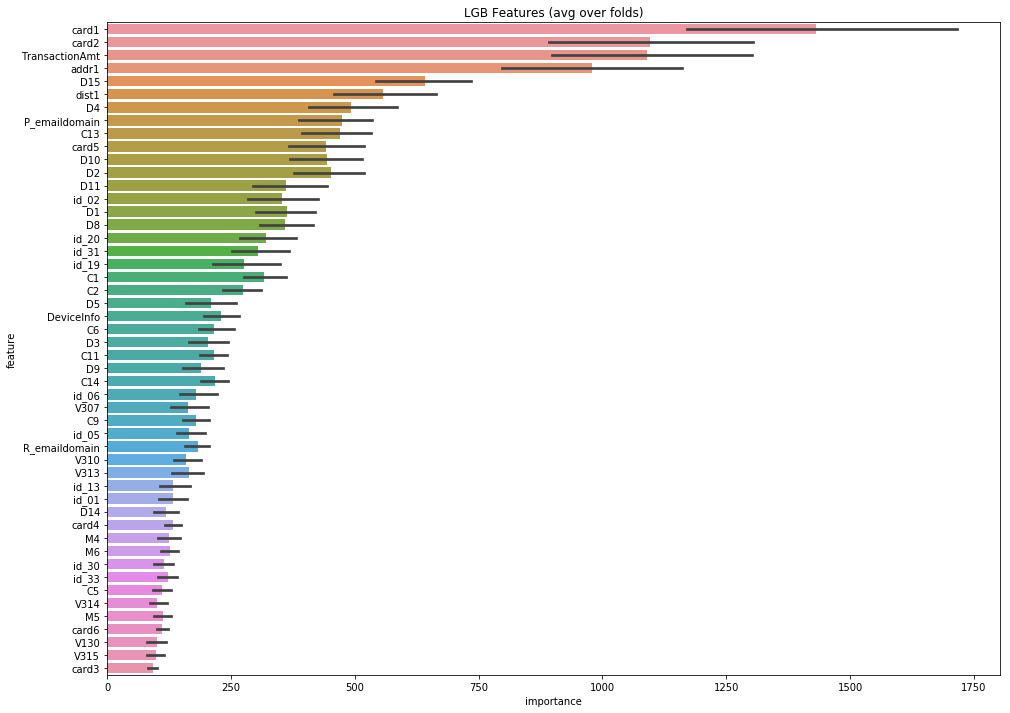

In [0]:
params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          #'categorical_feature': cat_cols
         }
result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='usual', n_jobs=-1)

In [0]:
# sample_submission.head()

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5


In [0]:
sample_submission['isFraud'] = result_dict_lgb['prediction']

##xgb

In [0]:
xgb_params = {'eta': 0.04,
              'max_depth': 5,
              'subsample': 0.85,
              'objective': 'binary:logistic',
              'eval_metric': 'auc',
              'silent': True,
              'nthread': -1,
              'tree_method': 'gpu_hist'}
result_dict_xgb = train_model_classification(X=X, X_test=X_test, y=y, params=xgb_params, folds=folds, model_type='xgb', eval_metric='auc', plot_feature_importance=False,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='rank')

Fold 1 started at Tue Sep  3 11:20:19 2019


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.765415	valid_data-auc:0.772437
Multiple eval metrics have been passed: 'valid_data-auc' will be used for early stopping.

Will train until valid_data-auc hasn't improved in 200 rounds.
[500]	train-auc:0.93749	valid_data-auc:0.893397
[1000]	train-auc:0.957447	valid_data-auc:0.904928
[1500]	train-auc:0.969254	valid_data-auc:0.909481
[2000]	train-auc:0.976502	valid_data-auc:0.911504
[2500]	train-auc:0.98181	valid_data-auc:0.911689
Stopping. Best iteration:
[2333]	train-auc:0.980188	valid_data-auc:0.911799

Fold 2 started at Tue Sep  3 12:00:08 2019


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.768715	valid_data-auc:0.780718
Multiple eval metrics have been passed: 'valid_data-auc' will be used for early stopping.

Will train until valid_data-auc hasn't improved in 200 rounds.
[500]	train-auc:0.938423	valid_data-auc:0.909229
[1000]	train-auc:0.956768	valid_data-auc:0.916765
[1500]	train-auc:0.968469	valid_data-auc:0.920332
[2000]	train-auc:0.976507	valid_data-auc:0.922362
[2500]	train-auc:0.981729	valid_data-auc:0.923379
Stopping. Best iteration:
[2762]	train-auc:0.984108	valid_data-auc:0.923638

Fold 3 started at Tue Sep  3 12:45:38 2019


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.770117	valid_data-auc:0.753946
Multiple eval metrics have been passed: 'valid_data-auc' will be used for early stopping.

Will train until valid_data-auc hasn't improved in 200 rounds.
[500]	train-auc:0.938546	valid_data-auc:0.904677
[1000]	train-auc:0.9583	valid_data-auc:0.91422
[1500]	train-auc:0.969849	valid_data-auc:0.917848
[2000]	train-auc:0.977398	valid_data-auc:0.919444
Stopping. Best iteration:
[1943]	train-auc:0.976658	valid_data-auc:0.919615

Fold 4 started at Tue Sep  3 13:18:30 2019


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.773239	valid_data-auc:0.780176
Multiple eval metrics have been passed: 'valid_data-auc' will be used for early stopping.

Will train until valid_data-auc hasn't improved in 200 rounds.
[500]	train-auc:0.93397	valid_data-auc:0.925024
[1000]	train-auc:0.95474	valid_data-auc:0.934199
[1500]	train-auc:0.967533	valid_data-auc:0.938737
[2000]	train-auc:0.975504	valid_data-auc:0.940629
[2500]	train-auc:0.981109	valid_data-auc:0.941254
Stopping. Best iteration:
[2504]	train-auc:0.981146	valid_data-auc:0.941289

Fold 5 started at Tue Sep  3 14:00:01 2019


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.74453	valid_data-auc:0.731931
Multiple eval metrics have been passed: 'valid_data-auc' will be used for early stopping.

Will train until valid_data-auc hasn't improved in 200 rounds.
[500]	train-auc:0.938353	valid_data-auc:0.904606
[1000]	train-auc:0.958153	valid_data-auc:0.912638
[1500]	train-auc:0.969304	valid_data-auc:0.914633
[2000]	train-auc:0.976799	valid_data-auc:0.915275
Stopping. Best iteration:
[1896]	train-auc:0.975439	valid_data-auc:0.915788

CV mean score: 0.9224, std: 0.0102.


In [0]:
sample_submission_xgb=sample_submission.copy()

In [0]:
test = test.sort_values('TransactionDT')
test['prediction'] = result_dict_xgb['prediction']
sample_submission_xgb['isFraud'] = pd.merge(sample_submission_xgb, test, on='TransactionID')['prediction']
sample_submission_xgb.to_csv('submission_xgb.csv', index=False)

In [0]:
test = test.sort_values('TransactionDT')
test['prediction'] = result_dict_lgb['prediction'] + result_dict_xgb['prediction']
sample_submission_xgb['isFraud'] = pd.merge(sample_submission_xgb, test, on='TransactionID')['prediction']
sample_submission_xgb.to_csv('blend.csv', index=False)

In [0]:
# sample_submission['isFraud']=ypred1

In [0]:
# sample_submission_xgb['isFraud']=result_dict_xgb['prediction']

In [0]:
sample_submission_xgb.head()

,TransactionID,isFraud
0,3663549,147522.801844
1,3663550,126158.201157
2,3663551,147451.202255
3,3663552,81153.002143
4,3663553,174279.501846


In [0]:
sample_submission.to_csv('final_sub.csv')